# **A full 1D analysis using the low-level Gammapy API**

**Objective: Performing a full spectral anaysis of the point source [PKS 2155-304](http://tevcat.uchicago.edu/?mode=1&showsrc=90)**

Here we demonstrate the data reduction and spectral fitting for a point like source, using the reflected regions background estimation method.

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define the reconstructed and true energy axes using the `~gammapy.maps.MapAxis` object
- Create the necessary makers : 
    - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker`
    - the reflected regions finder: either `~gammapy.makers.ReflectedRegionsFinder` or `~gammapy.makers.WobbleRegionsFinder`
    - the background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeMaskMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.SpectrumDatasetOnOff`
    - Stack it on the target one.
- Define the `~gammapy.modeling.models.SkyModel` to fit the data. Being this a spectral analysis, the `SkyModel` is completely defined by a  `~gammapy.modeling.models.SpectralModel` (no spatial information is required)
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, RegionGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets, SpectrumDataset
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator
from gammapy.data import DataStore
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [4]:
pos = SkyCoord.from_name("PKS 2155-304")
pos.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71693844, -30.22558846)>

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pos.ra,
    lat=pos.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [6]:
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


In [7]:
print(observations)

Observations
Number of observations: 21
Observation

	obs id            : 33787 
 	tstart            : 53945.85
	tstop             : 53945.87
	duration          : 1689.00 s
	pointing (icrs)   : 329.7 deg, -29.7 deg

	deadtime fraction : 2.5%
Observation

	obs id            : 33788 
 	tstart            : 53945.87
	tstop             : 53945.89
	duration          : 1689.00 s
	pointing (icrs)   : 329.1 deg, -30.2 deg

	deadtime fraction : 5.5%
Observation

	obs id            : 33789 
 	tstart            : 53945.89
	tstop             : 53945.91
	duration          : 1688.00 s
	pointing (icrs)   : 330.3 deg, -30.2 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 33790 
 	tstart            : 53945.91
	tstop             : 53945.93
	duration          : 1690.00 s
	pointing (icrs)   : 329.7 deg, -30.7 deg

	deadtime fraction : 7.6%
Observation

	obs id            : 33791 
 	tstart            : 53945.94
	tstop             : 53945.95
	duration          : 1689.00 s
	pointing (icrs)   

In [8]:
obs = observations[0]

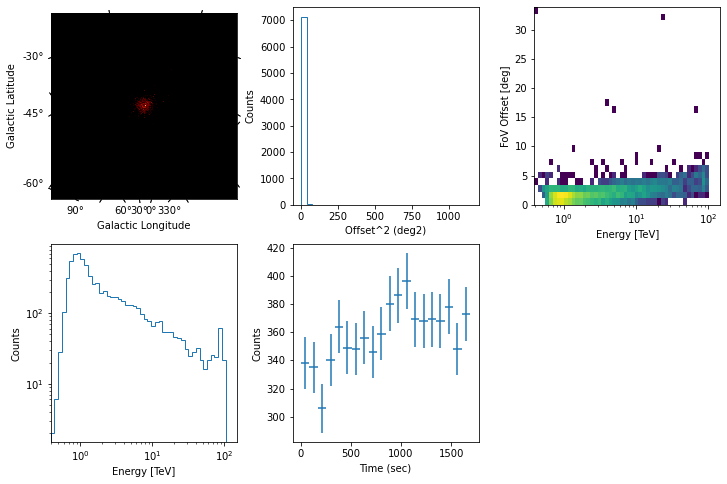

In [9]:
obs.events.peek()

## Preparing reduced datasets geometry

Now we define the reconstructed and true energy axes: 

In [10]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

We then define a ON region to extract the spectrum, and create the analysis geometry using the `RegionGeom` object:

In [11]:
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pos, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

Now we can define the target dataset with this geometry.

In [12]:
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

## Create exclusion mask

To perform the spectral analysis we must mask all the gamma ray emission in the analysis region, which would otherwise bias the background estimation. Here we are analyzing an extra-Galactic source, which is isolated and would not require a priori an exclusion mask. However, for illustration purpose, we choose a mask of 0.5 deg to the North of the blazar.

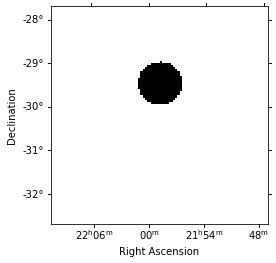

In [13]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(329.71, -29.5, unit="deg", frame="icrs"),
    radius=0.5 * u.deg,
)

skydir = pos.icrs
geom = WcsGeom.create(width=5*u.deg, binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

## Data reduction

### Create the maker classes to be used
We first initialize the `Maker` objects that will take care of the data reduction.

In particular, for the definition of the OFF regions one can choose between 2 objects: 
- The `ReflectedRegionsFinder` :  Finds set of OFF counts in the observation, by rotating the ON region selected around the pointing position (https://docs.gammapy.org/0.20/tutorials/analysis/1D/spectral_analysis.html). 
- The `WobbleRegionsFinder` : Useful if you have energy dependent rad-max cuts (https://docs.gammapy.org/0.20/tutorials/analysis/1D/spectral_analysis_rad_max.html) or you want to have more control on your region selection

Here, we show an example with the `WobbleRegionsFinder`.

In [14]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 2 off
region_finder = WobbleRegionsFinder(n_off_regions=2)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

### Perform the data reduction loop

For the moment the datasets are not stacked, but appended into a `Datasets` object (which basically contains a list of datasets). That's because we want to produce diagnostic plots such as the cumulative source significance as a function of the observation livetime. The stacking will be performed later on. 

In [15]:
%%time

datasets = Datasets()
for observation in observations:
    # First a spectrum dataset with the same geometry as the reference empty one is filled with the data and IRFs
    dataset = dataset_maker.run(
        dataset_empty.copy(name=observation.obs_id), observation)
    # Reflected regions background estimation
    dataset_on_off = bkg_maker.run(dataset, observation)
    # The data quality cut is applied
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    # The resulting dataset is appended to the list
    datasets.append(dataset_on_off)

CPU times: user 7.24 s, sys: 86.6 ms, total: 7.33 s
Wall time: 7.33 s


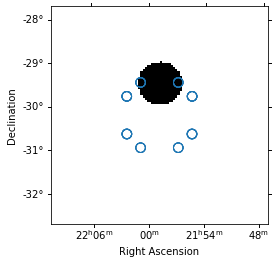

In [16]:
ax = exclusion_mask.plot()
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [17]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,92,82.5,10.767284240561896,9.5,37.0,37.0,nan,2947135.25,938975104.0,1645.943673139438,1689.0,0.05589498687067532,0.005771764948602343,0.050123221922072976,27,16,wstat,124.76800428147962,19,16.0,32.0,0.5
stacked,509,492.5,29.94129658755475,16.5,180.66666666666669,180.66666666666669,nan,3549789.5,1579164288.0,3242.045464714989,3378.0,0.15699964899929206,0.005089379584456422,0.15191026941483565,27,18,wstat,918.911068742291,33,18.0,36.0,0.5
stacked,1321,1297.0,50.25435679615148,24.0,456.33333333333326,456.33333333333326,nan,38543.67578125,2112657920.0,4825.489054074511,5066.0,0.2737546360994403,0.004973589149422079,0.2687810469500182,27,19,wstat,2562.036379919156,48,19.0,38.0,0.5
stacked,2206,2174.0,65.6963552880217,32.0,756.6666666666665,756.6666666666665,nan,163008.84375,2542220288.0,6386.866192122921,6756.0,0.3453963076165137,0.0050102818874562275,0.34038602572905746,27,20,wstat,4361.224431259612,64,20.0,40.0,0.5
stacked,3158,3115.5,78.87293197387494,42.5,1081.0,1081.0,nan,511080.0,2910420224.0,7954.743777347729,8445.0,0.3969958163822771,0.005342723938013545,0.39165309244426355,27,21,wstat,6276.397263825995,85,21.0,42.0,0.5
stacked,3932,3881.0,88.15091984637475,51.0,1344.6666666666667,1344.6666666666667,nan,3783955.25,3232583424.0,9517.102900041267,10133.0,0.4131509390302957,0.005358773624248495,0.4077921654060472,27,21,wstat,7836.385501603602,102,21.0,42.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,7759,7623.5,122.05956372095592,135.5,2676.6666666666665,2676.6666666666665,nan,45967708.0,7560448512.0,25258.837867734954,27021.0,0.30717961137519967,0.005364458994888459,0.3018151523803112,27,22,wstat,15042.248207141676,271,22.0,44.0,0.5


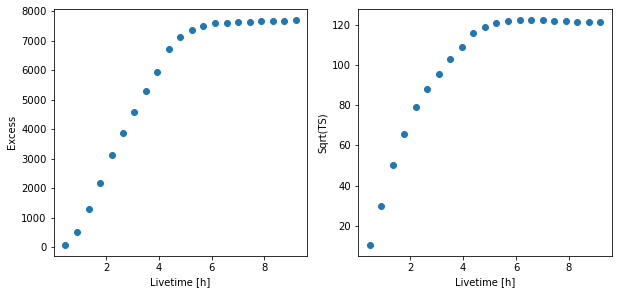

In [18]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax1.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
ax1.set_xlabel("Livetime [h]")
ax1.set_ylabel("Excess");


ax2 = plt.subplot(222)
ax2.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
ax2.set_xlabel("Livetime [h]")
ax2.set_ylabel("Sqrt(TS)");


Save the dataset to disc using `~gammapy.datasets.Datasets.write()` method:

In [19]:
filename = "pks-joint-dataset.fits.gz"
datasets.write(filename, overwrite=True)

Before fitting we stack the `Datasets` into a single `SpectrumDatasetOnOff`:

In [20]:
#create stacked
stacked = datasets.stack_reduce()

In [21]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : peb1dsKd 

  Total counts                    : 7878 
  Total background counts         : 176.00
  Total excess counts             : 7702.00

  Predicted counts                : 2743.33
  Predicted background counts     : 2743.33
  Predicted excess counts         : nan

  Exposure min                    : 4.60e+07 m2 s
  Exposure max                    : 9.70e+09 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 22 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14878.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 352 
  Acceptance                      : 27 
  Acceptance off                  : 54 



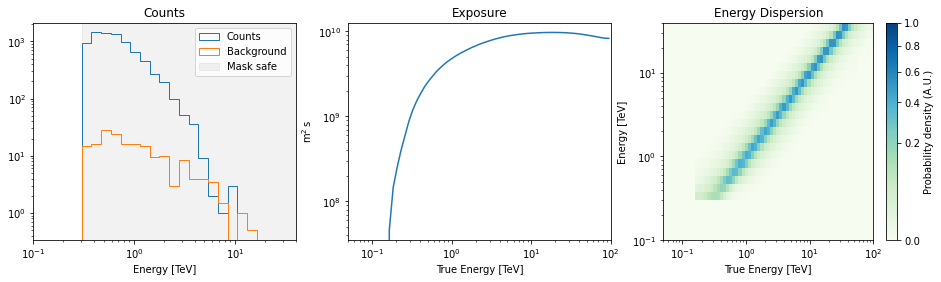

In [22]:
stacked.peek()

## Data Fitting

In this section we fit a spectral model to the data. We can try to answer the following questions:
- What is the significance of the detected source?
- What is the best spectral shape to describe the spectrum of the source? 

In particular, we can use the [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) to compare three different hypotheses:
- H0: Background only (no source)
- H1: Background + source described by a power law model
- H2: Background + source described by a power law model with exponential cutoff

### **H0**

The value of the quantity $-2\ln\mathcal(L)$ for the background-only model (null hypothesis) can be simply computed as

In [23]:
Wstat_0 = stacked.stat_sum()
print(Wstat_0)

14878.042748558766


Since the background has been estimated using the reflected regions method, here $-2\ln\mathcal(L)$ corresponds to the so-called [Wstat](https://docs.gammapy.org/0.20/stats/fit_statistics.html#wstat) fit statistic.

We can inspect the model residuals for the H0 hypothesis:

<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

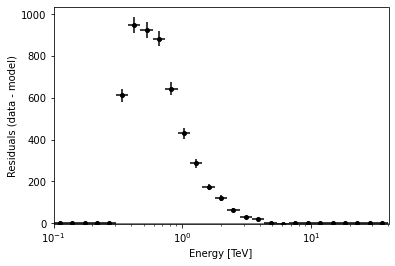

In [24]:
stacked.plot_residuals_spectral()

As expected, the residuals show a clear positive feature indicating that a source is missing in the model. 

## **H1**
We now add a source defined by a power law spectrum to the model.

Here we also consider EBL absorption (see: https://docs.gammapy.org/0.20/modeling/gallery/spectral/plot_absorbed.html?highlight=ebl).

In [25]:
spectral_model_pl = PowerLawSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
spectral_model_1 = spectral_model_pl * ebl

pks_model_1 = SkyModel(spectral_model=spectral_model_1,
                    name="pks_model")

In [26]:
pks_model_1.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [27]:
stacked.models = [pks_model_1]

In [28]:
%%time
fit1 = Fit(optimize_opts={"print_level": 1})
result1 = fit1.run(datasets=[stacked])

CPU times: user 995 ms, sys: 376 µs, total: 996 ms
Wall time: 990 ms


In [29]:
result1.success

True

In [30]:
result1.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str9,str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
pks_model,spectral,index,2.8450e+00,,2.314e-02,nan,nan,False,False,
pks_model,spectral,amplitude,1.9273e-10,cm-2 s-1 TeV-1,3.337e-12,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [31]:
Wstat_1 = result1.total_stat
print("delta TS of detection: ", (Wstat_0-Wstat_1), "p-value: ", chi2.sf((Wstat_0-Wstat_1), 2))

delta TS of detection:  14725.614615387016 p-value:  0.0


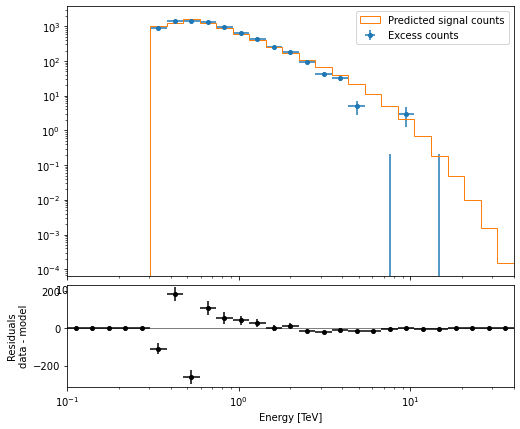

In [32]:
ax_spectrum, ax_residuals = stacked.plot_fit()

We can compute flux points for the H0 model assumption.

In [35]:
energy_edges = np.logspace(-1, 1.6, 12)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model_1.name, selection_optional=["ul"])

In the next cell we activate the progress bar functionality, which can be helpful for time-consuming tasks.

In [51]:
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True

In [52]:
%%time
flux_points = fpe.run(datasets=[stacked])

Energy bins:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 4.16 s, sys: 11 ms, total: 4.17 s
Wall time: 4.15 s


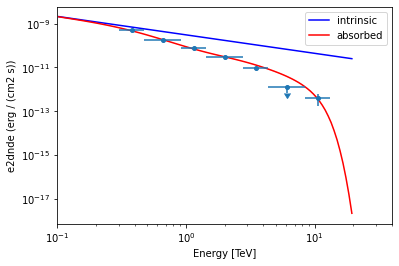

In [37]:
ax = spectral_model_pl.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model_1.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model_1.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend()

In [38]:
spectral_model_1.to_dict()

{'spectral': {'type': 'CompoundSpectralModel',
  'model1': {'type': 'PowerLawSpectralModel',
   'parameters': [{'name': 'index',
     'value': 2.844965460999378,
     'error': 0.023140969115219512,
     'is_norm': False},
    {'name': 'amplitude',
     'value': 1.9272906858363863e-10,
     'unit': 'cm-2 s-1 TeV-1',
     'error': 3.3373512432051802e-12,
     'is_norm': True},
    {'name': 'reference',
     'value': 1.0,
     'unit': 'TeV',
     'frozen': True,
     'is_norm': False}]},
  'model2': {'type': 'EBLAbsorptionNormSpectralModel',
   'parameters': [{'name': 'alpha_norm',
     'value': 1.0,
     'frozen': True,
     'is_norm': False},
    {'name': 'redshift',
     'value': 0.11599999999999999,
     'frozen': True,
     'is_norm': False}],
   'filename': '/home/lucagiunti/gammapy-datasets/ebl/ebl_dominguez11.fits.gz'},
  'operator': 'mul'}}

## **H2**

We now estimate the significance for the presence of an exponential cutoff in the source spectrum, again taking into account the EBL absorption.

In [39]:
spectral_model_ecpl = ExpCutoffPowerLawSpectralModel()
redshift = 0.116
spectral_model_2 = spectral_model_ecpl * ebl

pks_model_2 = SkyModel(spectral_model=spectral_model_2,
                    name="pks_model")

In [40]:
pks_model_2.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,1.5000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,lambda_,1.0000e-01,TeV-1,0.000e+00,nan,nan,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [41]:
stacked.models = [pks_model_2]

In [42]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[stacked])

/home/lucagiunti/miniconda3/envs/gammapy-0.20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 1.69 s, sys: 8.22 ms, total: 1.69 s
Wall time: 1.69 s


In [43]:
result2.success

True

In [44]:
result2.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str9,str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
pks_model,spectral,index,2.4672e+00,,7.194e-02,nan,nan,False,False,
pks_model,spectral,amplitude,3.1725e-10,cm-2 s-1 TeV-1,2.958e-11,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,lambda_,4.2249e-01,TeV-1,8.051e-02,nan,nan,False,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [45]:
Wstat_2 = result2.total_stat
print("delta TS of detection: ", (Wstat_1-Wstat_2), "p-value: ", chi2.sf((Wstat_1-Wstat_2), 1))

delta TS of detection:  37.873649778944625 p-value:  7.5477831507168e-10


We have successfully detected a cutoff in the observed spectrum.

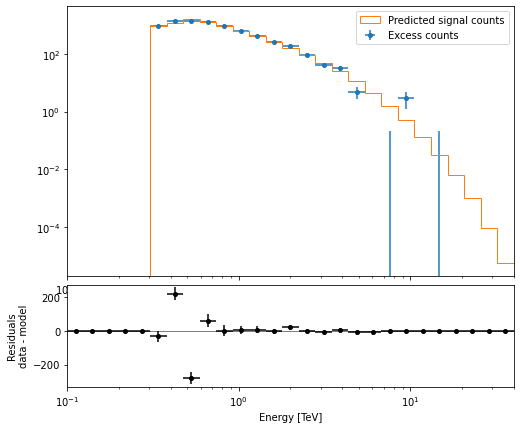

In [46]:
ax_spectrum, ax_residuals = stacked.plot_fit()

To check that the fit has coverged correctly, it is always a good idea to inspect the likelihood profile for the free model parameters.

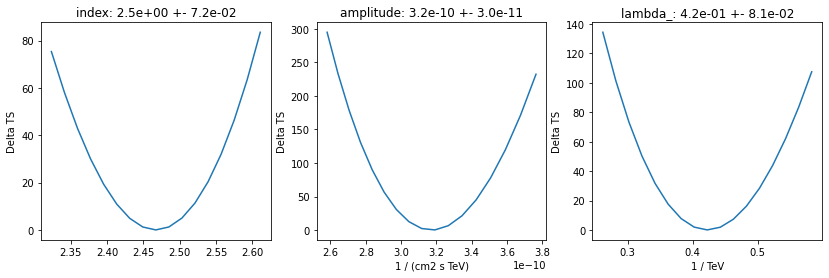

In [47]:
total_stat = result2.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model_2.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit2.stat_profile(datasets=[stacked], parameter=par)
    ax.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

We now compute the flux points for the H2 hypothesis.

In [48]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 3.95 s, sys: 7.35 ms, total: 3.96 s
Wall time: 3.95 s


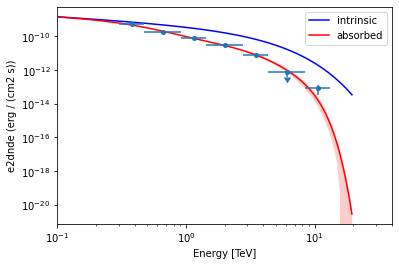

In [49]:
ax = spectral_model_ecpl.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model_2.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model_2.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend()

In [50]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
0.12484541354466076,0.10000000000000002,0.1558637728313736,4.90719291070116e-08,2.7712499814165102e-09,3.3976467416060003e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.21742229366110305,0.1558637728313736,0.3032934011676863,1.0897135426340852e-08,1.6595606843894175e-09,3.4358457090135013e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.37864790094146483,0.3032934011676863,0.47272453780854895,2.00160610581563e-09,3.483068755085378e-10,1.2814356408987775e-10,1.089268290947399,0.022749679625224464,1.1353876861011694,4656.753390397591,68.24040877953173,2369.101755686411,2338.1553,23.44478520939083,False,2369.0,True
0.6594274693415539,0.47272453780854895,0.9198688719186309,2.8550896819855835e-10,1.4134398473704592e-10,8.627305117726143e-11,0.9440215020789012,0.015806755048684694,0.9759772595295557,7102.3514920560665,84.27545011482327,3738.283960913639,3669.4316,39.967766055922766,False,3739.0,True
1.1484140972154202,0.9198688719186309,1.4337423288737732,3.541746181057031e-11,1.9228221628759786e-11,2.128849263844194e-11,1.0134245447740542,0.03154150420024887,1.0779247689096558,2001.3993601514157,44.737002136390586,1107.7909435477247,1076.7733,0.03373430521605769,False,1108.0,True
2.0,1.4337423288737732,2.789901587924842,4.382226542203865e-12,6.660629958261056e-12,1.224748021584201e-11,1.0399371674960607,0.04631295807461271,1.135143229060267,946.5789806123445,30.766523700482388,559.570795764225,536.868,1.8369215327925303,False,560.0,True
3.483064174933826,2.789901587924842,4.34844587322206,4.0322286703594653e-13,6.884075505009135e-13,2.2740509689401222e-12,0.9870126972989657,0.12862152006692296,1.2607608473624332,90.76485377561949,9.527059030761775,86.86639392761428,74.30312,2.4651006407921443,False,87.0,True
6.065868023353727,4.34844587322206,8.461587415248545,1.662726856906262e-14,1.055453887216378e-13,5.462542912192515e-13,0.23401597758005666,0.23396013157781234,0.7558110517800267,1.0706577259876884,1.0347259182931914,12.711439612567213,4.066392,2.351241714970597,True,12.0,True


# Exercises:

## Beginner
- Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/0.19/modeling/gallery/index.html 
- What is the impact of changing the on regions (their number, shape, finding method)? 
- Try to repeat the fit using a different minimizer. By default Gammapy uses Minuit, but it also supports the Sherpa and Scipy backends.

## Advanced
- Create a gammapy.estimators.FluxPointsDataset with the flux points you have computed for the stacked dataset and fit the flux points again with obe of the spectral models. How does the result compare to the best fit model, that was directly fitted to the counts data?
- Compute a 2-dimensional likelihood contour to estimate the correlation between the fitted parameters (e.g. the spectral index and cutoff). (Tutorial reference: https://docs.gammapy.org/0.20/tutorials/api/fitting.html)
- Repeat exercise on the Crab runs available in GAMMAPY_DATA. Alternatively, if you have access to CTA DC1 simulated data, repeat on your favourite source 